# Stimulus-Evoked Activity under *in vivo*-like conditions

In [1]:
import numpy as np
from scipy.stats import sem

from cell_template import BRANCH_COLORS
from parallel import Parallel

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

--No graphics will be displayed.


# Protocol Description

- synapses splitted in excitatory (80%) and inhibitory (20%) categories
- background excitatory+inhibitory synaptic events at a given frequency (events through Poisson process)
- stimulus events: a set of synaptic events randomly picked within the excitatory population
- stimulus stength variable: **$n_{syn}$** the number of randomly picked synapses
- simulations on a per branch basis -- considering only the synapses of a given branch -- performing simulations on each branch
- firing response in Hz measured in [0,100]ms window following the stimulus

### Example Simulation
Run the below example with:
```
python stim_on_background.py --test -c Martinotti --nCluster 5 15 25 35 45 --bgStimFreq 1e-3 --bgFreqInhFactor 1 --nStimRepeat 2 --with_presynaptic_spikes
```

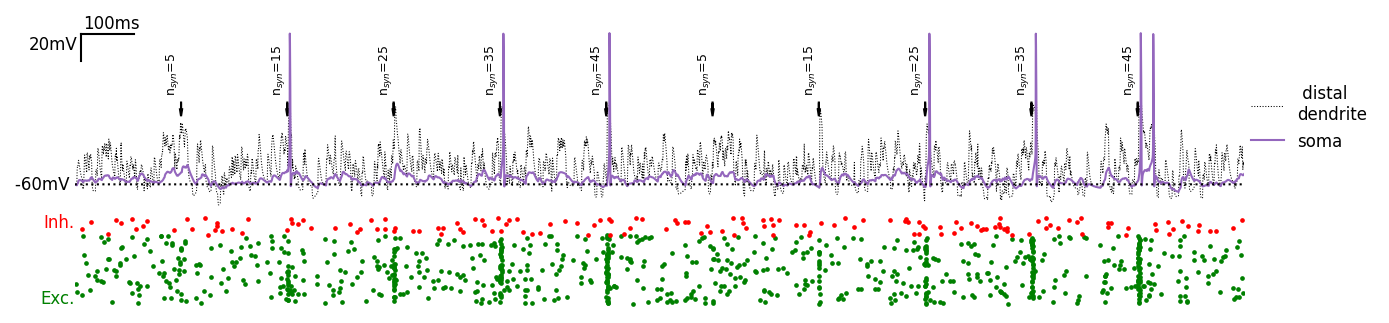

In [3]:
results = np.load('single_sim.npy', allow_pickle=True).item()

t = np.arange(len(results['Vm_soma']))*results['dt']
fig, AX = pt.figure(axes_extents=[[(1,2)],[(1,1)]],
                    figsize=(3,1), left=0, bottom=0., hspace=0.)
for r in range(int(results['nStimRepeat'])):
    for c, nC in enumerate(results['nCluster']):
        tstart = results['t0']+r*len(results['nCluster'])*results['ISI']+c*results['ISI']
        pt.arrow(AX[0], [tstart, 0, 0, -10],
                 head_width=4, head_length=5, width=0.1)
        pt.annotate(AX[0], 'n$_{syn}$=%i' % nC, (tstart, 5), 
                    rotation=90, xycoords='data', fontsize=6, ha='right')
AX[0].plot(t, results['Vm_dend'], 'k:', lw=0.5, label=' distal\ndendrite')
AX[0].plot(t, results['Vm_soma'], 'tab:purple', label='soma')
AX[0].plot(t, -60+0*t, 'k:')
pt.annotate(AX[0], '-60mV ', (0,-60), xycoords='data', ha='right', va='center')
pt.draw_bar_scales(AX[0], Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
AX[0].legend(frameon=False, loc=(1, 0.3))
for i, events in enumerate(results['presynaptic_exc_events']):
    AX[1].plot(events, i*np.ones(len(events)), '.', color='g')
for i, events in enumerate(results['presynaptic_inh_events']):
    AX[1].plot(events, len(results['presynaptic_exc_events'])+i*np.ones(len(events)), '.', 
               color='r')
pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')

pt.set_common_xlims(AX, lims=[t[0], t[-1]])
for ax in AX:
    ax.axis('off')

### Functions to Load and Analyze the Simulation Data

In [96]:
def load_params_from(sim):
    p = {}
    for k in ['dt', 'nStimRepeat', 'ISI', 't0']:
        p[k] = sim.fetch_quantity_on_grid(k, dtype=float, return_last=True) 
    p['nCluster'] = sim.fetch_quantity_on_grid('nCluster', dtype=object, return_last=True)
    return p

def show_Vm_trace(sim, 
                  loc='soma',
                  iBranch=0, 
                  varied_key = 'with_NMDA',
                  plot = {'with-NMDA':{'varied_key':True,
                                       'color':'tab:orange',
                                       'lw':1.0},
                          'without':{'varied_key':False,
                                    'color':'tab:grey',
                                    'lw':0.5}},
                  zoom=None):
    
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    params = dict(iBranch=iBranch)

    fig, ax = pt.figure(figsize=(2.5,2), left=0.2, bottom=0.5)

    Vms = {}
    for label in plot:
        params[varied_key] = plot[label]['varied_key']
        Vm = sim.get('Vm_%s' % loc, params)[0]
        t = np.arange(len(Vm))*p['dt']
        if zoom is not None:
            Vm = Vm[(t>zoom[0]) & (t<zoom[1])]
            t = t[(t>zoom[0]) & (t<zoom[1])]
        else:
            zoom=[t[0], t[-1]]
        ax.plot(t, Vm, label=label, color=plot[label]['color'], lw=plot[label]['lw'])

    for r in range(int(p['nStimRepeat'])):
        for c, nC in enumerate(p['nCluster']):
            tstart = p['t0']+r*len(p['nCluster'])*p['ISI']+c*p['ISI']
            if (tstart>zoom[0]) and (tstart<zoom[1]):
                pt.arrow(ax, [tstart, 0, 0, -10],
                         head_width=4, head_length=5, width=0.1)
                pt.annotate(ax, 'n$_{syn}$=%i' % nC, (tstart, 5), 
                            rotation=90, xycoords='data', fontsize=6, ha='right')
            
    ax.axis('off')
    ax.legend(loc=(1,0.4), frameon=False)
    pt.draw_bar_scales(ax, Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
    return fig

def extract_trials(sim, 
                  loc='soma',
                  varied_key = 'with_NMDA',
                  true_false_labels=['with-NMDA', 'without'],
                  pre=-30, post=150):
    """
    returns elements of shape:
               VMs     (nBranch, nStims, nStimRepeat, nTimeSamples)
               SPIKES  (nBranch, nStims, nStimRepeat, nTimeSamples)
    """
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    nBranch = len(np.unique(sim.iBranch))
    nStims = len(p['nCluster'])
    VMs, SPIKEs, RATEs = {}, {}, {}
    
    for l, label in enumerate(true_false_labels):
        VMs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)))
        SPIKEs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)), dtype=int)
        RATEs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)), dtype=float)
        
        for iBranch in np.unique(sim.iBranch):
            
            params = {varied_key:(label==true_false_labels[0]),
                      'iBranch':iBranch}

            Vm = sim.get('Vm_%s' % loc, params)[0]
            
            _, VMs[label][iBranch, :, :, :], SPIKEs[label][iBranch, :, :, :] = \
                    trial_alignement(Vm, p, pre=pre, post=post)
            RATEs[label][iBranch, :, :, :] = 1e3*SPIKEs[label][iBranch, :, :, :]/p['dt']
            
    return T, VMs, SPIKEs, RATEs
    
def trial_alignement(Vm, p, 
                     spike_threshold=-20,
                     pre=-30, post=150):
    
    t = np.arange(len(Vm))*p['dt']
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    VMs = np.zeros((len(p['nCluster']), int(p['nStimRepeat']), len(T)))
    SPIKEs = np.zeros((len(p['nCluster']), int(p['nStimRepeat']), len(T)), dtype=int)
    for r in range(int(p['nStimRepeat'])):
        for c, nC in enumerate(p['nCluster']):
            tstart = p['t0']+r*len(p['nCluster'])*p['ISI']+c*p['ISI']
            cond = t>=(tstart+T[0])
            VMs[c,r,:] = Vm[cond][:len(T)]
            # count spikes
            iSpks =np.argwhere((VMs[c,r,:][1:]>=spike_threshold) & (VMs[c,r,:][:-1]<spike_threshold))
            SPIKEs[c,r,1:][iSpks] = 1
        
    return T, VMs, SPIKEs

def func(x, x0, s, A):
    # error function
    return A*(erf(s*(x-x0))+1)/2.

# Basket Cell

### Demo Simulation

```
python stim_on_background.py -c Basket --nCluster 5 15 25 35 45 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 10 --test_uniform --suffix Demo --with_presynaptic_spikes
```

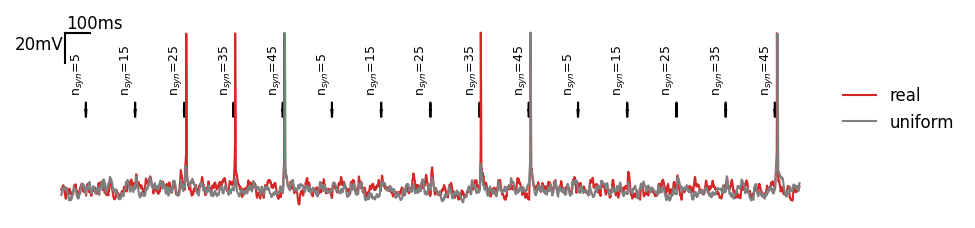

In [8]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simDemo_Basket.zip')
sim.load()
t0 = 100
fig = show_Vm_trace(sim, iBranch=1, zoom=[t0,t0+3000],
              varied_key = 'from_uniform',
              plot = {'real':{'varied_key':False,
                              'color':'tab:red',
                                       'lw':1.0},
                      'uniform':{'varied_key':True,
                                 'color':'tab:grey',
                                 'lw':1.0}})
fig.savefig('../../figures/detailed_model/raw-stim-with-bg-Basket.eps')
fig.savefig('../../figures/detailed_model/raw-stim-with-bg-Basket.svg')

## Full Simulations

```
python stim_on_background.py -c Basket --nCluster 0 5 10 15 20 25 30 35 40 45 50 55 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 100 --test_uniform --suffix Full --ISI 400 
```

In [119]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simFull_Basket.zip')
sim.load()

In [120]:
T, VMs, SPIKEs, RATEs = extract_trials(sim,
                                       loc='soma',
                                       varied_key = 'from_uniform',
                                       true_false_labels=['uniform', 'real'],
                                       pre=0, post=100)

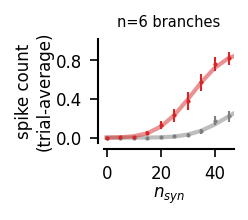

In [147]:
fig, ax = pt.figure(figsize=(1.,1.1))
xlim=[-1,47]

for l, label, color in zip(range(2), ['uniform', 'real'], ['tab:grey', 'tab:red']):
    spike_count = SPIKEs[label][:,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
    pt.scatter(np.unique(sim.nCluster)[0], np.mean(spike_count, axis=0),
               sy=sem(spike_count, axis=0), ms=1,
               color=color, ax=ax)
    # fit
    x, y = np.array(np.unique(sim.nCluster)[0]), np.mean(spike_count, axis=0)
    def to_minimize(P):
        return np.abs(y[x<xlim[1]]-func(x[x<xlim[1]], *P)).sum()
    res = minimize(to_minimize, [x[-1]/2., 
                                 1./(x[-1]/2.), y.max()],
                  method='Nelder-Mead')
    pt.plot(x, func(x, *res.x), color=color, ax=ax, lw=2, alpha=.5)
    
pt.set_plot(ax, xlabel='$n_{syn}$'  , 
            #yticks=[0,0.5,1],
            xlim=[-1,47],
            xticks=[0, 20, 40], #xticks_labels=['5', '', '25', '', '45'],
            ylabel='spike count\n(trial-average)')
ax.set_title('n=6 branches', fontsize=7)
fig.savefig('../../figures/detailed_model/spiking-responses-Basket.svg')


uniform: 38.3 +/- 8.0 
real: 20.8 +/- 4.5 
p-value: 4.5e-04



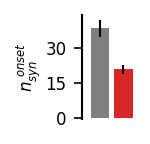

In [156]:
from scipy import stats
fig, ax = pt.figure(figsize=(.6,1.1))

x = np.array(np.unique(sim.nCluster)[0])
xlim=[-1,51]
Nsyn = {}
for l, label, color in zip(range(2),
                           ['uniform', 'real'],
                           ['tab:grey', 'tab:red']):
    Nsyn[label] = []
    x = np.array(np.unique(sim.nCluster)[0])
    for b in range(6):
        spike_count = SPIKEs[label][b,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
   
        def to_minimize(P):
            return np.abs(spike_count[x<xlim[1]]-func(x[x<xlim[1]], *P)).sum()
        
        res = minimize(to_minimize, [x[-1]/2.,
                                     1./(x[-1]/2.),
                                     spike_count.max()],
                      method='Nelder-Mead')
        Nsyn[label].append(x[func(x, *res.x)>0.05][0])
        
    ax.bar([l], [np.mean(Nsyn[label])], yerr=[stats.sem(Nsyn[label])], color=color)

print("""
uniform: %.1f +/- %.1f 
real: %.1f +/- %.1f 
p-value: %.1e
""" % (np.mean(Nsyn['uniform']), np.std(Nsyn['uniform']),
       np.mean(Nsyn['real']), np.std(Nsyn['real']),
       stats.ttest_rel(Nsyn['uniform'], Nsyn['real']).pvalue))
pt.set_plot(ax, ['left'], ylabel='$n_{syn}^{\,\,onset}$')
fig.savefig('../../figures/detailed_model/summary-spiking-responses-Basket.svg')

# Martinotti Cell

### Demo Simulation

```
python stim_on_background.py -c Martinotti --nCluster 5 15 25 35 45 --bgStimFreq 5e-4 --bgFreqInhFactor 1 --nStimRepeat 10 --test_NMDA --suffix Demo
```

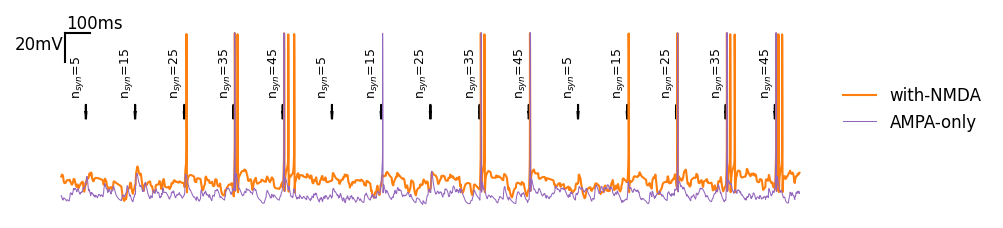

In [8]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simDemo_Martinotti.zip')
sim.load()
t0 = 3100
fig = show_Vm_trace(sim, iBranch=1, zoom=[t0,t0+3000],
              varied_key = 'with_NMDA',
              plot = {'with-NMDA':{'varied_key':True,
                                       'color':'tab:orange',
                                       'lw':1.0},
                      'AMPA-only':{'varied_key':False,
                                   'color':'tab:purple',
                                   'lw':0.5}})
fig.savefig('../../figures/detailed_model/raw-stim-with-bg-Martinotti.eps')
fig.savefig('../../figures/detailed_model/raw-stim-with-bg-Martinotti.svg')

## Full Simulation

```
python stim_on_background.py -c Martinotti --nCluster 0 5 10 15 20 25 30 35 40 45 --bgStimFreq 5e-4 --bgFreqInhFactor 1 --nStimRepeat 100 --test_NMDA --suffix Full --ISI 400
```

In [157]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simFull_Martinotti.zip')
sim.load()
T, VMs, SPIKEs, RATEs = extract_trials(sim,
                                       loc='soma',
                                       varied_key = 'with_NMDA',
                                       true_false_labels=['with-NMDA', 'without'],
                                       pre=0, post=100)

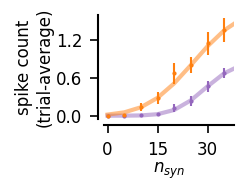

In [159]:
fig, ax = pt.figure(figsize=(1.,1.1))
x, MEANS = np.array(np.unique(sim.nCluster)[0]), []
for l, label, color in zip(range(2), ['without', 'with-NMDA'], ['tab:purple', 'tab:orange']):
    spike_count = SPIKEs[label][:,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
    pt.scatter(np.unique(sim.nCluster)[0], np.mean(spike_count, axis=0),
               sy=sem(spike_count, axis=0), ms=1,
               color=color, ax=ax)
    # fit
    x, y = np.array(np.unique(sim.nCluster)[0]), np.mean(spike_count, axis=0)
    def to_minimize(P):
        return np.abs(y-func(x, *P)).sum()
    res = minimize(to_minimize, [x[-1]/2., 
                                 1./(x[-1]/2.), y.max()],
                  method='Nelder-Mead')
    pt.plot(x, func(x, *res.x), color=color, ax=ax, lw=2, alpha=.5)
    
pt.set_plot(ax, xlabel='$n_{syn}$'  , #yticks=[0,1],
            xlim=[-1,38], ylim=[-0.05,1.6],
            #xticks=[0, 20, 40], 
            #xticks_labels=['5', '', '25', '', '45'],
            ylabel='spike count\n(trial-average)')
fig.savefig('../../figures/detailed_model/spiking-responses-Martinotti.svg')


without: 22.5 +/- 3.8 
with: 8.3 +/- 3.7 
p-value: 1.3e-05



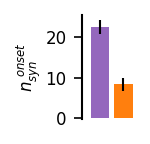

In [161]:
from scipy import stats
fig, ax = pt.figure(figsize=(.6,1.1))

x = np.array(np.unique(sim.nCluster)[0])

Nsyn = {}
for l, label, color in zip(range(2), ['without', 'with-NMDA'], ['tab:purple', 'tab:orange']):
    Nsyn[label] = []
    x = np.array(np.unique(sim.nCluster)[0])
    for b in range(6):
        spike_count = SPIKEs[label][b,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
   
        def to_minimize(P):
            return np.abs(spike_count[x<xlim[1]]-func(x[x<xlim[1]], *P)).sum()
        
        res = minimize(to_minimize, [x[-1]/2.,
                                     1./(x[-1]/2.),
                                     spike_count.max()],
                      method='Nelder-Mead')
        Nsyn[label].append(x[func(x, *res.x)>0.05][0])
        
    ax.bar([l], [np.mean(Nsyn[label])],
           yerr=[stats.sem(Nsyn[label])], color=color)

print("""
without: %.1f +/- %.1f 
with: %.1f +/- %.1f 
p-value: %.1e
""" % (np.mean(Nsyn['without']), np.std(Nsyn['without']),
       np.mean(Nsyn['with-NMDA']), np.std(Nsyn['with-NMDA']),
       stats.ttest_rel(Nsyn['without'], Nsyn['with-NMDA']).pvalue))
pt.set_plot(ax, ['left'], ylabel='$n_{syn}^{\,\,onset}$',)
fig.savefig('../../figures/detailed_model/summary-spiking-responses-Martinotti.svg')